In [4]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      classifier(random_state=i) )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,random_state=i+1)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    

In [5]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

# censor the 'answers'
features2drop = [(f,a) for f,a in divisions.columns if 'Time' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'smoothed' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'standard' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'cell coords' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'Manual' in f]
features2drop += ['Z','Z-cyto']
divisions = divisions.drop(columns=features2drop)
print(len(divisions))

# Load images
from skimage import io
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}

tracked_cyto_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif')) for name,dirname in dirnames.items()}
tracked_nuc_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_nuc.tif')) for name,dirname in dirnames.items()}
adjdict_by_region = {name: [np.load(path.join(dirname,f'Mastodon/basal_connectivity_3d/adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item() for t in range(15)] for name,dirname in dirnames.items()}

%loadext autoreload
%autoreload 2

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_8794/2990578711.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  divisions = divisions.drop(columns=features2drop)


668


UsageError: Line magic function `%loadext` not found.


In [ ]:
# Run classifier
# axis0: observation axis1: prediction

from sklearn import svm

feature2predict = 'At least one daughter differentiated'
divisions = divisions.dropna(subset=[(feature2predict,'Meta')])
divisions = divisions.dropna(axis=1)

print(divisions.shape)
predictions,models = predict_feature(divisions,
                                     svm.LinearSVC,
                                     feature2predict,Niter=100)


In [19]:
divisions.droplevel(axis=1,level=1).sort_values(by='Mean curvature 5um').tail(10)['LineageID']

Frame  TrackID
3      R2_307     113.0
8      R2_813     245.0
0      R1_760     232.0
12     R2_854     254.0
10     R2_916     267.0
12     R1_802     241.0
5      R2_598     194.0
8      R1_722     223.0
2      R2_699     221.0
5      R2_937     272.0
Name: LineageID, dtype: float64

NameError: name 'dirname' is not defined

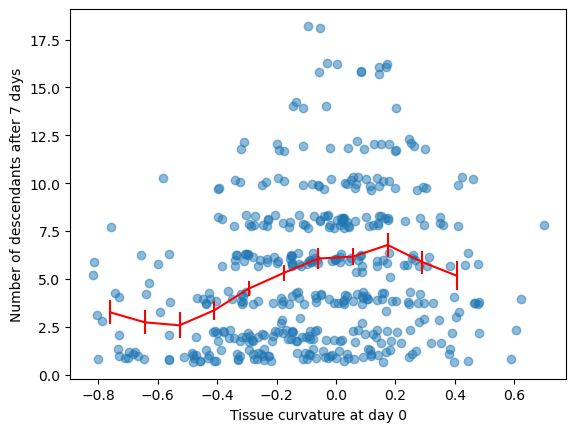

In [33]:
lineages[1].index.get_level_values(1).unique()

Index(['R1_1', 'R2_1', 'R2_2', 'R2_3'], dtype='object', name='TrackID')